<a href="https://colab.research.google.com/github/gkdivya/CNN/blob/master/EVAP2S5_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(degrees=(5),fill=(0,)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [29]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [30]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

NameError: ignored

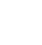

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee104becc0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [31]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),            
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [32]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             180
       BatchNorm2d-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           3,600
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           1,800
      BatchNorm2d-10           [-1, 10, 22, 22]              20
          Dropout-11           [-1, 10, 22, 22]               0
             ReLU-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [34]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    scheduler.step() 
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.4161691665649414 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.4161691665649414 Batch_id=0 Accuracy=7.81:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=2.354346513748169 Batch_id=1 Accuracy=10.94:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=2.354346513748169 Batch_id=1 Accuracy=10.94:   0%|          | 2/469 [00:00<01:39,  4.68it/s]
Loss=2.346609592437744 Batch_id=2 Accuracy=11.46:   0%|          | 2/469 [00:00<01:39,  4.68it/s]
Loss=2.26918625831604 Batch_id=3 Accuracy=12.89:   0%|          | 2/469 [00:00<01:39,  4.68it/s] 
Loss=2.2520885467529297 Batch_id=4 Accuracy=14.38:   0%|          | 2/469 [00:00<01:39,  4.68it/s]
Loss=2.2520885467529297 Batch_id=4 Accuracy=14.38:   1%|          | 5/469 [00:00<01:14,  6.20it/s]
Loss=2.1142332553863525 Batch_id=5 Accuracy=16.28:   1%|          | 5/469 [00:00<01:14,  6.20it/s]
Loss=2.108522891998291 Batch_id=6 Accuracy=18.30:   1%|          | 5/469 [00:00<01:14,  6.20it/s] 
Loss=2.05100679397583 B


Test set: Average loss: 0.0892, Accuracy: 9737/10000 (97.37%)

EPOCH: 1



Loss=0.12756186723709106 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.12756186723709106 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.14527659118175507 Batch_id=1 Accuracy=94.92:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.11070051044225693 Batch_id=2 Accuracy=95.83:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.11344228684902191 Batch_id=3 Accuracy=96.29:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.062049731612205505 Batch_id=4 Accuracy=96.72:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.062049731612205505 Batch_id=4 Accuracy=96.72:   1%|          | 5/469 [00:00<01:50,  4.19it/s]
Loss=0.11038316786289215 Batch_id=5 Accuracy=96.88:   1%|          | 5/469 [00:00<01:50,  4.19it/s] 
Loss=0.07914972305297852 Batch_id=6 Accuracy=96.99:   1%|          | 5/469 [00:00<01:50,  4.19it/s]
Loss=0.12464966624975204 Batch_id=7 Accuracy=96.88:   1%|          | 5/469 [00:00<01:50,  4.19it/s]
Loss


Test set: Average loss: 0.0471, Accuracy: 9849/10000 (98.49%)

EPOCH: 2



Loss=0.0871964544057846 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0871964544057846 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=0.07734107971191406 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=0.11261384189128876 Batch_id=2 Accuracy=96.88:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=0.08749387413263321 Batch_id=3 Accuracy=96.88:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=0.08749387413263321 Batch_id=3 Accuracy=96.88:   1%|          | 4/469 [00:00<01:42,  4.53it/s]
Loss=0.028262842446565628 Batch_id=4 Accuracy=97.34:   1%|          | 4/469 [00:00<01:42,  4.53it/s]
Loss=0.03175778687000275 Batch_id=5 Accuracy=97.66:   1%|          | 4/469 [00:00<01:42,  4.53it/s] 
Loss=0.026042625308036804 Batch_id=6 Accuracy=97.88:   1%|          | 4/469 [00:00<01:42,  4.53it/s]
Loss=0.026042625308036804 Batch_id=6 Accuracy=97.88:   1%|▏         | 7/469 [00:00<01:16,  6.05it/s]
Loss=


Test set: Average loss: 0.0416, Accuracy: 9872/10000 (98.72%)

EPOCH: 3



Loss=0.15464994311332703 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.15464994311332703 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.047143276780843735 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.06710151582956314 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:37,  2.98it/s] 
Loss=0.09711848199367523 Batch_id=3 Accuracy=97.27:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.049569420516490936 Batch_id=4 Accuracy=97.66:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.049569420516490936 Batch_id=4 Accuracy=97.66:   1%|          | 5/469 [00:00<01:53,  4.11it/s]
Loss=0.06551004201173782 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:53,  4.11it/s] 
Loss=0.0412970632314682 Batch_id=6 Accuracy=97.77:   1%|          | 5/469 [00:00<01:53,  4.11it/s] 
Loss=0.07509182393550873 Batch_id=7 Accuracy=97.66:   1%|          | 5/469 [00:00<01:53,  4.11it/s]
Lo


Test set: Average loss: 0.0338, Accuracy: 9892/10000 (98.92%)

EPOCH: 4



Loss=0.07255998253822327 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07255998253822327 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.09634245187044144 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.111037477850914 Batch_id=2 Accuracy=96.09:   0%|          | 1/469 [00:00<02:18,  3.38it/s]  
Loss=0.111037477850914 Batch_id=2 Accuracy=96.09:   1%|          | 3/469 [00:00<01:45,  4.43it/s]
Loss=0.037149716168642044 Batch_id=3 Accuracy=96.88:   1%|          | 3/469 [00:00<01:45,  4.43it/s]
Loss=0.051546767354011536 Batch_id=4 Accuracy=97.03:   1%|          | 3/469 [00:00<01:45,  4.43it/s]
Loss=0.11397361755371094 Batch_id=5 Accuracy=96.88:   1%|          | 3/469 [00:00<01:45,  4.43it/s] 
Loss=0.06202468276023865 Batch_id=6 Accuracy=97.10:   1%|          | 3/469 [00:00<01:45,  4.43it/s]
Loss=0.06202468276023865 Batch_id=6 Accuracy=97.10:   1%|▏         | 7/469 [00:00<01:17,  5.93it/s]
Loss=0


Test set: Average loss: 0.0325, Accuracy: 9899/10000 (98.99%)

EPOCH: 5



Loss=0.02483963593840599 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.02483963593840599 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.08820983022451401 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.051905348896980286 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.04010951146483421 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:30,  3.11it/s] 
Loss=0.11169356852769852 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.11169356852769852 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:48,  4.26it/s]
Loss=0.03653876483440399 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:48,  4.26it/s]
Loss=0.08150079846382141 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:48,  4.26it/s]
Loss=0.04389026015996933 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:48,  4.26it/s]
Loss=


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 6



Loss=0.04508230462670326 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.04508230462670326 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.023301400244235992 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.042554669082164764 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.005991566926240921 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.04957076162099838 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s] 
Loss=0.04957076162099838 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:47,  4.33it/s]
Loss=0.05690528452396393 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<01:47,  4.33it/s]
Loss=0.020204491913318634 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:47,  4.33it/s]
Loss=0.02411617338657379 Batch_id=7 Accuracy=98.63:   1%|          | 5/469 [00:00<01:47,  4.33it/s] 
L


Test set: Average loss: 0.0267, Accuracy: 9909/10000 (99.09%)

EPOCH: 7



Loss=0.022485781461000443 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.022485781461000443 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.03127052262425423 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:19,  3.35it/s] 
Loss=0.08022338896989822 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.024936392903327942 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.03977300226688385 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:19,  3.35it/s] 
Loss=0.03977300226688385 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:41,  4.58it/s]
Loss=0.022665653377771378 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<01:41,  4.58it/s]
Loss=0.09858731180429459 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:41,  4.58it/s] 
Loss=0.04154318571090698 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:41,  4.58it/s]



Test set: Average loss: 0.0275, Accuracy: 9906/10000 (99.06%)

EPOCH: 8



Loss=0.006808452308177948 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.006808452308177948 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.07950395345687866 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:30,  3.11it/s]  
Loss=0.04559905081987381 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.05003805086016655 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:30,  3.11it/s]
Loss=0.05003805086016655 Batch_id=3 Accuracy=98.63:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.016107451170682907 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.062064364552497864 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.04510445147752762 Batch_id=6 Accuracy=98.66:   1%|          | 4/469 [00:00<01:49,  4.23it/s] 
Loss=0.04510445147752762 Batch_id=6 Accuracy=98.66:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s


Test set: Average loss: 0.0261, Accuracy: 9907/10000 (99.07%)

EPOCH: 9



Loss=0.03660411387681961 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.03660411387681961 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.05916518345475197 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.05809003487229347 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.05477847531437874 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.05477847531437874 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<01:51,  4.17it/s]
Loss=0.02310444787144661 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<01:51,  4.17it/s]
Loss=0.0647604912519455 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:51,  4.17it/s] 
Loss=0.03547867015004158 Batch_id=6 Accuracy=98.10:   1%|          | 4/469 [00:00<01:51,  4.17it/s]
Loss=0.021641474217176437 Batch_id=7 Accuracy=98.34:   1%|          | 4/469 [00:00<01:51,  4.17it/s]
Loss=0


Test set: Average loss: 0.0262, Accuracy: 9912/10000 (99.12%)

EPOCH: 10



Loss=0.05116137117147446 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05116137117147446 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:55,  4.06it/s]
Loss=0.08970293402671814 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:55,  4.06it/s]
Loss=0.04644960165023804 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<01:55,  4.06it/s]
Loss=0.04644960165023804 Batch_id=2 Accuracy=97.92:   1%|          | 3/469 [00:00<01:27,  5.32it/s]
Loss=0.05830904468894005 Batch_id=3 Accuracy=98.05:   1%|          | 3/469 [00:00<01:27,  5.32it/s]
Loss=0.010684926062822342 Batch_id=4 Accuracy=98.44:   1%|          | 3/469 [00:00<01:27,  5.32it/s]
Loss=0.03674287721514702 Batch_id=5 Accuracy=98.57:   1%|          | 3/469 [00:00<01:27,  5.32it/s] 
Loss=0.018034677952528 Batch_id=6 Accuracy=98.66:   1%|          | 3/469 [00:00<01:27,  5.32it/s]  
Loss=0.018034677952528 Batch_id=6 Accuracy=98.66:   1%|▏         | 7/469 [00:00<01:05,  7.06it/s]
Loss=0.


Test set: Average loss: 0.0259, Accuracy: 9907/10000 (99.07%)

EPOCH: 11



Loss=0.024503260850906372 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.024503260850906372 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:32,  3.06it/s]
Loss=0.09052267670631409 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:32,  3.06it/s] 
Loss=0.06833071261644363 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:32,  3.06it/s]
Loss=0.0079672671854496 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:32,  3.06it/s] 
Loss=0.0079672671854496 Batch_id=3 Accuracy=98.63:   1%|          | 4/469 [00:00<01:50,  4.19it/s]
Loss=0.011373091489076614 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:50,  4.19it/s]
Loss=0.03625793009996414 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:50,  4.19it/s] 
Loss=0.01927860826253891 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:00<01:50,  4.19it/s]
Loss=0.04645736142992973 Batch_id=7 Accuracy=98.73:   1%|          | 4/469 [00:00<01:50,  4.19it/s]
Los


Test set: Average loss: 0.0266, Accuracy: 9907/10000 (99.07%)

EPOCH: 12



Loss=0.039859920740127563 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.039859920740127563 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.62it/s]
Loss=0.042305510491132736 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:09,  3.62it/s]
Loss=0.014400042593479156 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.62it/s]
Loss=0.04983796551823616 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:09,  3.62it/s] 
Loss=0.04983796551823616 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:35,  4.88it/s]
Loss=0.03001929074525833 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:35,  4.88it/s]
Loss=0.023185189813375473 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:35,  4.88it/s]
Loss=0.05358925834298134 Batch_id=6 Accuracy=98.77:   1%|          | 4/469 [00:00<01:35,  4.88it/s] 
Loss=0.05358925834298134 Batch_id=6 Accuracy=98.77:   1%|▏         | 7/469 [00:00<01:11,  6.49it/s]



Test set: Average loss: 0.0261, Accuracy: 9907/10000 (99.07%)

EPOCH: 13



Loss=0.030959581956267357 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.030959581956267357 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:40,  2.92it/s]
Loss=0.06296217441558838 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:40,  2.92it/s] 
Loss=0.06265020370483398 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:40,  2.92it/s]
Loss=0.007152639329433441 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:40,  2.92it/s]
Loss=0.007152639329433441 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:57,  3.97it/s]
Loss=0.046958912163972855 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<01:57,  3.97it/s]
Loss=0.01850084960460663 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:57,  3.97it/s] 
Loss=0.04612714424729347 Batch_id=6 Accuracy=98.77:   1%|          | 4/469 [00:00<01:57,  3.97it/s]
Loss=0.0119224414229393 Batch_id=7 Accuracy=98.93:   1%|          | 4/469 [00:00<01:57,  3.97it/s] 



Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)

EPOCH: 14



Loss=0.05830832198262215 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05830832198262215 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.06608085334300995 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.09826533496379852 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.05980829522013664 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.05980829522013664 Batch_id=3 Accuracy=97.46:   1%|          | 4/469 [00:00<02:01,  3.83it/s]
Loss=0.0441012866795063 Batch_id=4 Accuracy=97.50:   1%|          | 4/469 [00:00<02:01,  3.83it/s] 
Loss=0.05995733290910721 Batch_id=5 Accuracy=97.40:   1%|          | 4/469 [00:00<02:01,  3.83it/s]
Loss=0.03761183097958565 Batch_id=6 Accuracy=97.66:   1%|          | 4/469 [00:00<02:01,  3.83it/s]
Loss=0.03761183097958565 Batch_id=6 Accuracy=97.66:   1%|▏         | 7/469 [00:00<01:29,  5.19it/s]
Loss=0.


Test set: Average loss: 0.0262, Accuracy: 9908/10000 (99.08%)

EPOCH: 15



Loss=0.040925607085227966 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.040925607085227966 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:23,  3.26it/s]
Loss=0.020535122603178024 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:23,  3.26it/s]
Loss=0.030185144394636154 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:23,  3.26it/s]
Loss=0.03608269989490509 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:23,  3.26it/s] 
Loss=0.012752290815114975 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:23,  3.26it/s]
Loss=0.012752290815114975 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:43,  4.46it/s]
Loss=0.11726462841033936 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:43,  4.46it/s] 
Loss=0.0055854432284832 Batch_id=6 Accuracy=98.77:   1%|          | 5/469 [00:00<01:43,  4.46it/s] 
Loss=0.017810888588428497 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:43,  4.46it/s


Test set: Average loss: 0.0258, Accuracy: 9908/10000 (99.08%)

EPOCH: 16



Loss=0.02210327610373497 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.02210327610373497 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.39it/s]
Loss=0.02905193902552128 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.39it/s]
Loss=0.08627962321043015 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:17,  3.39it/s]
Loss=0.03235115483403206 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:17,  3.39it/s]
Loss=0.03235115483403206 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:40,  4.61it/s]
Loss=0.021905023604631424 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<01:40,  4.61it/s]
Loss=0.02712360769510269 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<01:40,  4.61it/s] 
Loss=0.06492752581834793 Batch_id=6 Accuracy=98.44:   1%|          | 4/469 [00:00<01:40,  4.61it/s]
Loss=0.04442758858203888 Batch_id=7 Accuracy=98.54:   1%|          | 4/469 [00:00<01:40,  4.61it/s]
Loss=


Test set: Average loss: 0.0260, Accuracy: 9908/10000 (99.08%)

EPOCH: 17



Loss=0.012858811765909195 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.012858811765909195 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.020541515201330185 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:23,  3.27it/s] 
Loss=0.05340545251965523 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:23,  3.27it/s] 
Loss=0.009846866130828857 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.047096576541662216 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:23,  3.27it/s]
Loss=0.047096576541662216 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:43,  4.48it/s]
Loss=0.04993702471256256 Batch_id=5 Accuracy=98.96:   1%|          | 5/469 [00:00<01:43,  4.48it/s] 
Loss=0.10312149673700333 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:43,  4.48it/s]
Loss=0.020876605063676834 Batch_id=7 Accuracy=98.54:   1%|          | 5/469 [00:00<01:43,  4.48i


Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

EPOCH: 18



Loss=0.023568736389279366 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.023568736389279366 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.023607000708580017 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.010252270847558975 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.010474290698766708 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<02:28,  3.16it/s]
Loss=0.010474290698766708 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.04531816393136978 Batch_id=4 Accuracy=99.22:   1%|          | 4/469 [00:00<01:48,  4.30it/s] 
Loss=0.10562200099229813 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.04897250235080719 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.025054115802049637 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<01:48,  4.30it/s]


Test set: Average loss: 0.0256, Accuracy: 9909/10000 (99.09%)

EPOCH: 19



Loss=0.014006558805704117 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.014006558805704117 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.019255515187978745 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.01it/s] 
Loss=0.0194733664393425 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:35,  3.01it/s]  
Loss=0.02182750403881073 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.018627438694238663 Batch_id=4 Accuracy=99.38:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.018627438694238663 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:51,  4.14it/s]
Loss=0.09819038957357407 Batch_id=5 Accuracy=98.96:   1%|          | 5/469 [00:00<01:51,  4.14it/s] 
Loss=0.015717871487140656 Batch_id=6 Accuracy=99.11:   1%|          | 5/469 [00:00<01:51,  4.14it/s]
Loss=0.0419452004134655 Batch_id=7 Accuracy=99.02:   1%|          | 5/469 [00:00<01:51,  4.14it/


Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")